# Assignment 1

Your assignment notebook goes here.


/tmp/ipykernel_72846/460365788.py:20: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = sp.signal.hamming(samples)


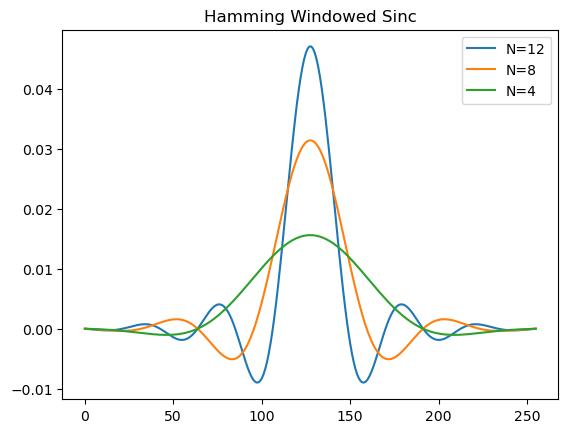

In [6]:
# Import your libraries here
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import sys

#gyro = 42.576E6*1.5 #MHz/T; the 1T gyromagnetic ratio. Upscaled for 1.5T.
gyro = 42.576E6 #MHz/T; the 1T gyromagnetic ratio. 
#but we are working in gauss, not Tesla, so its 1000x smaller
gyro = 42.576E6*1E-4 #MHz/Gauss; the 1T gyromagnetic ratio. 


def wsinc(timebandwidth, samples):
    #windowed sinc
    #for sincs, timebandwidth product is twice the number of zero crossings.
    n = timebandwidth/2#num zeros
    time = np.linspace(-n, n, samples)
    rf = sp.special.sinc(time)
    window = sp.signal.hamming(samples)
    rf = rf*window
    rf = rf/ rf.sum() #normalize
    return rf

n = 8
plt.title(f"Hamming Windowed Sinc")
for n in np.flip(np.asarray([4, 8, 12])):
    plt.plot(wsinc(n, 256), label=f"N={n}")
plt.legend()
plt.show()






/tmp/ipykernel_72846/460365788.py:20: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = sp.signal.hamming(samples)


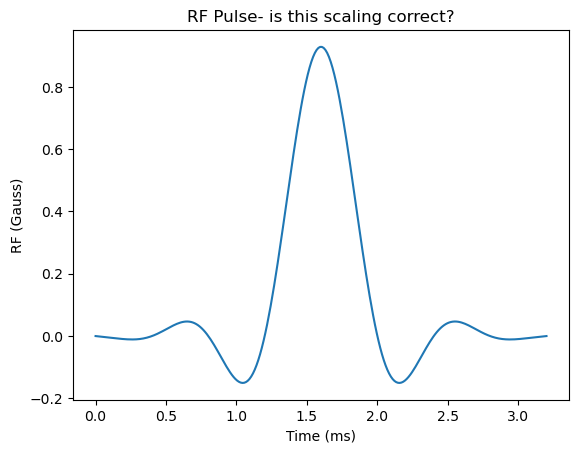

In [7]:
#question 2: 
def rf_scale_g(rf, pulse_duration):
    gyro = 4257 #hz/gauss
    #scale rf to have its amplitude in Gauss. 
    #sum of a waveform is its final flip angle. 
    #rf[k] = 'small flip angle' = gyro*B1[k]*dt 
    dt = pulse_duration/len(rf)
    B1 = rf/gyro/dt 
    #B1= B1T * 1E4 # 1T = 10,000 Gauss
    return B1

time = np.linspace(0, 3.2e-3, 256)
rf = np.pi/2*wsinc(8, len(time))
rf_gauss = rf_scale_g(rf, time[-1])
plt.plot(time*1e3, rf_gauss)    
plt.xlabel('Time (ms)')
plt.ylabel('RF (Gauss)')
plt.title('RF Pulse- is this scaling correct?')
plt.show()




/tmp/ipykernel_72846/460365788.py:20: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = sp.signal.hamming(samples)


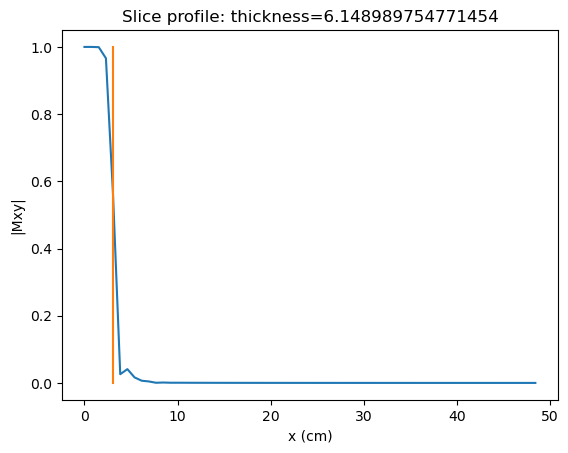

In [8]:
#question 3:
from abrm import *
from ab2ex import *


def gt2cm(x,g,t):
    #converts unitless spatial x vector to spatial position in cm. 
    #  g == G/ cm 
    #  t == ms
    # grad area:
    g_area = g*t * 1E-3 #converts ms to S. 
    kmax = gyro/(2*np.pi)*g_area *1/2 # Area under slice select lobe is 2kmax.
    #question, when does gyro come in? 
    dx = 1/(2*kmax) 
    x_cm = x*dx
    return x_cm
timebandwidth=8
rf = np.pi/2*wsinc(timebandwidth, 256)
x = np.arange(0,64) #unitless voxels
g = 0.6#Gauss/cm
t = 3.2#ms
xt = gt2cm(x, g, t) #cm

(a,b) = abrm(rf, x)
mxy = ab2ex(a,b)

#from lec2 notes: #gyro/(2*np.pi)*grad*delZ = BW
BW = timebandwidth/(t*1E-3)
delZ = BW * 2*np.pi/gyro * 1/g


plt.plot( xt, abs(mxy))
plt.plot([delZ/2,delZ/2], [0,1], label='Slice Thickness')
plt.xlabel('x (cm)')
plt.ylabel('|Mxy|')
plt.title(f'Slice profile: thickness={delZ}')
plt.show()




/tmp/ipykernel_72846/460365788.py:20: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = sp.signal.hamming(samples)


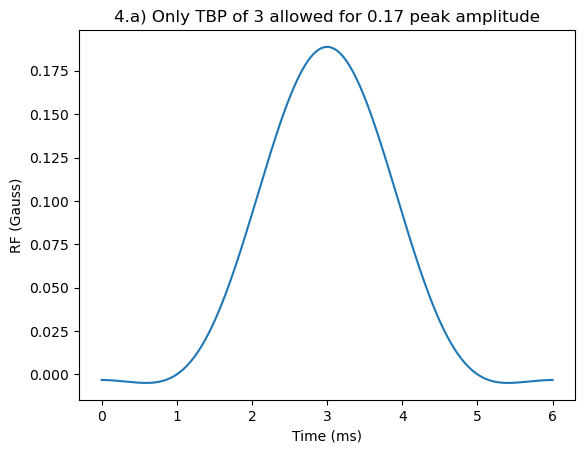

Grad = 0.09223484632157179 Gauss/cm for 8cm slice


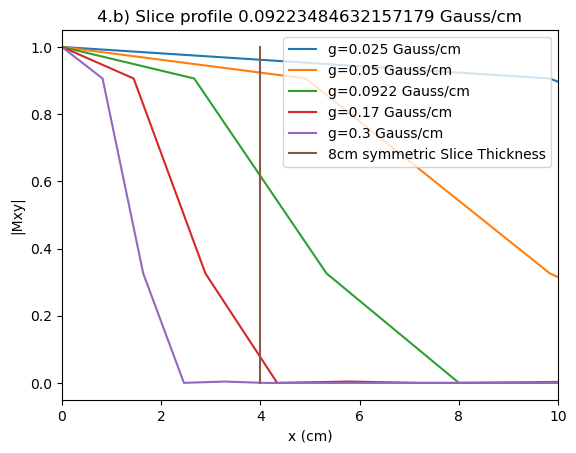

In [14]:
#Q4 design a slab pulse. 
#
# 6mS, 0.17G peak RF amplitude.

#a.) whats the highest time bw you can allow, given max flip angle of 90deg? 
t = 6e-3
time = np.linspace(0, t, 256)
timebandwidth = 3
rf = np.pi/2*wsinc(timebandwidth, len(time)) # scaled to 90deg
rf_gauss = rf_scale_g(rf, time[-1])
plt.plot(time*1e3, rf_gauss)    
plt.xlabel('Time (ms)')
plt.ylabel('RF (Gauss)')
plt.title(f'4.a) Only TBP of {timebandwidth} allowed for 0.17 peak amplitude')#RF Pulse- is this scaling correct?')
plt.show()

#b.) what is the grad amplitude required for 8cm slab thickness?
#from lec2 notes: #gyro/(2*np.pi)*grad*delZ = BW
BW = timebandwidth/(t)
delZ = 8
grad = BW * 2*np.pi/gyro * 1/delZ
print(f"Grad = {grad} Gauss/cm for 8cm slice")

x = np.arange(0,256) #unitless voxels
t = t*1E3# convert to ms
for g in [0.025,0.05,0.0922, 0.17,0.3]:
    xt = gt2cm(x, g, t) #cm
    (a,b) = abrm(rf, x=x)
    mxy = ab2ex(a,b)

    plt.plot( xt, abs(mxy), label=f'g={g} Gauss/cm')
plt.plot([4,4], [0,1], label='8cm symmetric Slice Thickness')
plt.xlim(0,10)
plt.xlabel('x (cm)')
plt.ylabel('|Mxy|')
plt.title(f'4.b) Slice profile {grad} Gauss/cm')
plt.legend()
plt.show()

